Make sure you have tensorflow 2.0 beta installed. Run the following cell if you don't

In [0]:
# !pip install tensorflow==2.0.0-beta1

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import csv

plt.style.use('seaborn')

In [0]:
# function to plot a series
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

Data is in the following format:<br/>
Date,Open,High,Low,Close,Adj Close,Volume<br/>
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300<br/>
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800<br/>
<br/>
We will use 'Adj Close' as our time series value (column 5) 

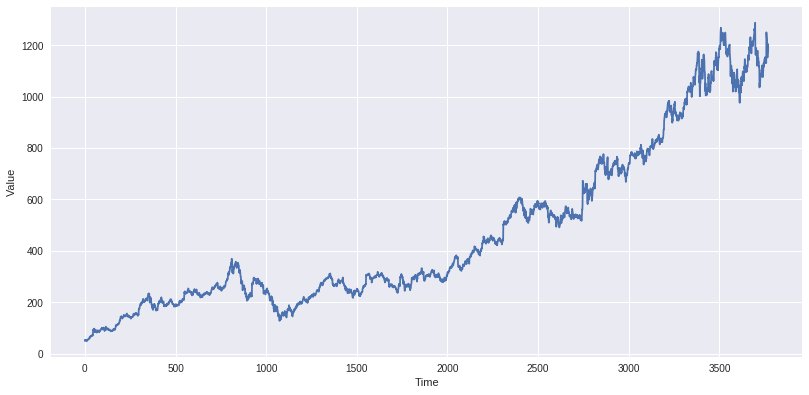

In [0]:
time_step = []
price = []

with open('GOOG.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    price.append(float(row[5]))
    time_step.append(step)
    step += 1

# print(step) -- 3770
series = np.array(price)
time = np.array(time_step)
plt.figure(figsize=(12,6))
plot_series(time, series)

In [0]:
# Split series in train and validation sets
split_time = 3500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 64
shuffle_buffer_size = 1000

In [0]:
# helper function to create dataset from the series

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [0]:
# function to forecast

def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(123)
np.random.seed(123)
window_size = 20
batch_size = 64

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                                 strides=1, padding='causal',
                                 activation='relu', input_shape=[None, 1]),
          tf.keras.layers.LSTM(64, return_sequences=True),
          tf.keras.layers.LSTM(64, return_sequences=True),
          tf.keras.layers.Dense(30, activation='relu'),
          tf.keras.layers.Dense(10, activation='relu'),
          tf.keras.layers.Dense(1),
          tf.keras.layers.Lambda(lambda x: x * 4000)                                    
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-9 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-9, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
55/55 [==============================] - 6s 100ms/step - loss: 185.1151 - mae: 184.7801
Epoch 2/100
55/55 [==============================] - 2s 43ms/step - loss: 164.7350 - mae: 164.3170
Epoch 3/100
55/55 [==============================] - 2s 43ms/step - loss: 144.9995 - mae: 144.5185
Epoch 4/100
55/55 [==============================] - 2s 44ms/step - loss: 136.9164 - mae: 136.4167
Epoch 5/100
55/55 [==============================] - 2s 44ms/step - loss: 130.9526 - mae: 130.4329
Epoch 6/100
55/55 [==============================] - 2s 43ms/step - loss: 126.2431 - mae: 125.7113
Epoch 7/100
55/55 [==============================] - 2s 44ms/step - loss: 122.2937 - mae: 121.7586
Epoch 8/100
55/55 [==============================] - 2s 44ms/step - loss: 119.1502 - mae: 118.6247
Epoch 9/100
55/55 [==============================] - 2s 44ms/step - loss: 116.5164 - mae: 116.0103
Epoch 10/100
55/55 [==============================] - 2s 44ms/step - loss: 114.2278 - mae: 113.7393
Epoch 11

[1e-09, 0.01, 0, 300]

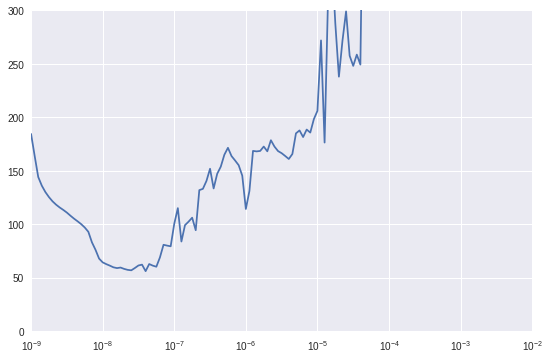

In [0]:
# plot learning rate vs loss to find optimal learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-9, 1e-2, 0, 300])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(123)
np.random.seed(123)
train_set = windowed_dataset(x_train, window_size=20, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 4000)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set,epochs=500)

Epoch 1/500
55/55 [==============================] - 8s 139ms/step - loss: 200.9552 - mae: 200.8908
Epoch 2/500
55/55 [==============================] - 3s 64ms/step - loss: 207.7387 - mae: 207.5730
Epoch 3/500
55/55 [==============================] - 4s 64ms/step - loss: 233.5747 - mae: 233.3346
Epoch 4/500
55/55 [==============================] - 4s 65ms/step - loss: 218.7422 - mae: 218.3612
Epoch 5/500
55/55 [==============================] - 3s 63ms/step - loss: 208.5637 - mae: 208.1206
Epoch 6/500
55/55 [==============================] - 4s 65ms/step - loss: 213.3219 - mae: 213.0526
Epoch 7/500
55/55 [==============================] - 4s 66ms/step - loss: 212.8326 - mae: 212.6044
Epoch 8/500
55/55 [==============================] - 4s 66ms/step - loss: 211.5394 - mae: 211.4469
Epoch 9/500
55/55 [==============================] - 4s 64ms/step - loss: 190.1793 - mae: 190.0092
Epoch 10/500
55/55 [==============================] - 3s 64ms/step - loss: 211.4069 - mae: 211.4996
Epoch 11

<Figure size 576x396 with 0 Axes>

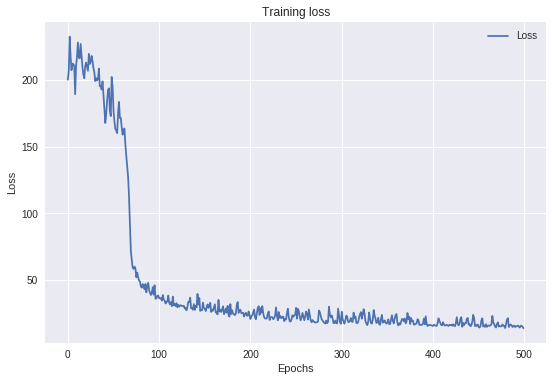

<Figure size 576x396 with 0 Axes>

In [0]:
import matplotlib.image as mpimg

loss = history.history['loss']
epochs = range(len(loss))

# plot training loss per epoch
plt.plot(epochs, loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])

plt.figure()

<Figure size 576x396 with 0 Axes>

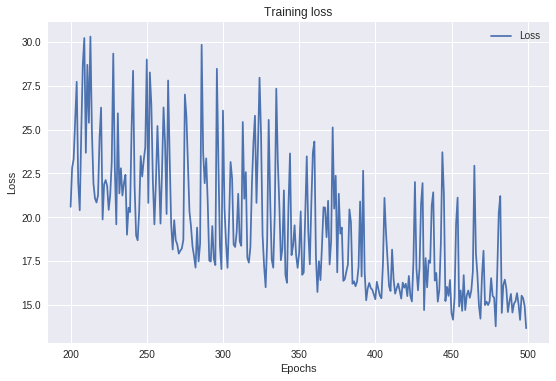

<Figure size 576x396 with 0 Axes>

In [0]:
# zoom in to the loss plot from 140 epochs

zoomed_loss = loss[200:]
zoomed_epochs = range(200, 500)

plt.plot(zoomed_epochs, zoomed_loss)
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [0]:
window_size = 20
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

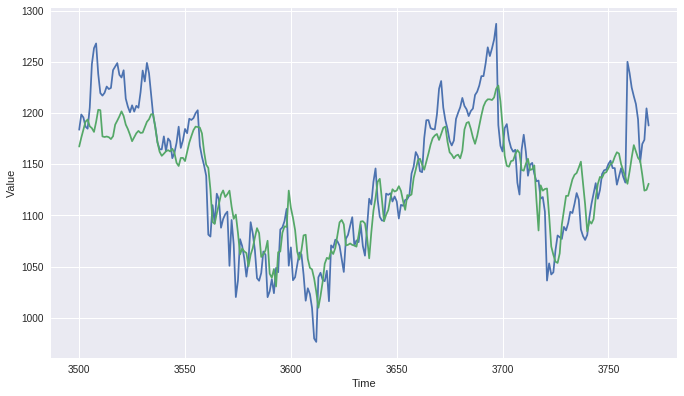

In [0]:
# Plot actual and prediction
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
# mean absolute error
print("MAE: ", tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())
print("MAPE: ", tf.keras.metrics.mean_absolute_percentage_error(x_valid, rnn_forecast).numpy())

MAE:  25.909609
MAPE:  2.2650654
